# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [17]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import pickle
from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.graph_objects as go
from collections import Counter

# 1. K Nearest Neighbour

# 1.1 Importing Data Sets

In [3]:
data= pd.read_csv("preprocessed_data.csv")
data.head(10)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
5,ca,mrs,grades_3_5,6,1,math_science history_civics,mathematics socialsciences,it end school year routines run course student...,102.50
6,ca,mrs,grades_3_5,0,1,literacy_language math_science,literacy mathematics,sitting still overrated it makes sense opera m...,1418.08
7,ca,ms,grades_3_5,0,0,math_science history_civics,appliedsciences history_geography,it not enough read book write essay connect de...,495.29
8,ca,ms,grades_prek_2,127,1,literacy_language,esl literacy,never society rapidly changed technology invad...,299.99
9,hi,mrs,grades_3_5,41,1,math_science,appliedsciences mathematics,do remember first time saw star wars wall e ro...,479.94


In [4]:
y=data['project_is_approved'].values
X=data.drop(['project_is_approved'],axis=1)
X.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h1>2. Naive Bayes </h1>

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [6]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)# since we are using grid search no need of extra cross validation data

# Make Data Model Ready: encoding eassay(text feature)

# Bag Of Words

In [43]:
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,3), max_features=6000)
vectorizer_bow.fit(X_train['essay'].values)

X_train_essay_bow = vectorizer_bow.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_bow.transform(X_test['essay'].values)
zss
print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizations
(73196, 6000) (73196,)
(36052, 6000) (36052,)


# TFIDF VECTORIZER

In [44]:
tfidfvectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3),max_features=6000)
text_tfidf = tfidfvectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf =tfidfvectorizer.transform(X_train['essay'].values) 
X_test_essay_tfidf =tfidfvectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(73196, 6000) (73196,)
(36052, 6000) (36052,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

# encoding categorical features: teacher_prefix

In [45]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
vectorizer_prefix = CountVectorizer()
vectorizer_prefix.fit(X_train['teacher_prefix'].values)

X_train_teacher = vectorizer_prefix.transform(X_train['teacher_prefix'].values) 
X_test_teacher = vectorizer_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher.shape, y_train.shape)
print(X_test_teacher.shape, y_test.shape)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)


# encoding categorical features: project_grade_category

In [46]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values)

X_train_project_grade = vectorizer_grade.transform(X_train['project_grade_category'].values) 
X_test_project_grade = vectorizer_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade.shape, y_train.shape)
print(X_test_project_grade.shape, y_test.shape)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)


# encoding categorical features: school_state

In [47]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values)

X_train_school_state = vectorizer_state.transform(X_train['school_state'].values) 
X_test_school_state = vectorizer_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state.shape, y_train.shape)
print(X_test_school_state.shape, y_test.shape)

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)


# encoding categorical features: clean_categories

In [48]:
vectorizer_category = CountVectorizer()
vectorizer_category.fit(X_train['clean_categories'].values)

X_train_clean_categories = vectorizer_category.transform(X_train['clean_categories'].values) 
X_test_clean_categories = vectorizer_category.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories.shape, y_train.shape)
print(X_test_clean_categories.shape, y_test.shape)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)


# encoding categorical features: clean_subcategories

In [49]:
vectorizer_subcategory = CountVectorizer()
vectorizer_subcategory.fit(X_train['clean_subcategories'].values)

X_train_clean_subcategories = vectorizer_subcategory.transform(X_train['clean_subcategories'].values) 
X_test_clean_subcategories = vectorizer_subcategory.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories.shape, y_train.shape)
print(X_test_clean_subcategories.shape, y_test.shape)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# encoding numerical feature :price

In [50]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm =X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# encoding numerical features:teacher_number_of_previously_posted_projects

In [51]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_submission_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm =X_train_submission_norm .reshape(-1,1)
X_test_submission_norm=X_test_submission_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_submission_norm.shape, y_train.shape)
print(X_test_submission_norm.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# Concatinating all the features

# SET-1

Set 1: categorical, numerical features + preprocessed_eassay (BOW)

In [52]:
from scipy.sparse import hstack
X_train_set = hstack((X_train_essay_bow, X_train_teacher, X_train_project_grade, X_train_school_state, X_train_clean_categories, X_train_clean_subcategories, X_train_price_norm, X_train_submission_norm)).tocsr()
X_test_set = hstack((X_test_essay_bow, X_test_teacher, X_test_project_grade, X_test_school_state, X_test_clean_categories, X_test_clean_subcategories, X_test_price_norm, X_test_submission_norm)).tocsr()

In [53]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_train_set.shape)
print(X_test_set.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 6101)
(36052, 6101)


# SET-2

Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)

In [54]:
from scipy.sparse import hstack
X_train_set_two = hstack((X_train_essay_tfidf, X_train_teacher, X_train_project_grade, X_train_school_state, X_train_clean_categories, X_train_clean_subcategories, X_train_price_norm, X_train_submission_norm)).tocsr()
X_test_set_two = hstack((X_test_essay_tfidf, X_test_teacher, X_test_project_grade, X_test_school_state, X_test_clean_categories, X_test_clean_subcategories, X_test_price_norm, X_test_submission_norm)).tocsr()

In [55]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_train_set_two.shape)
print(X_test_set_two.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 6101)
(36052, 6101)


# MULTINOMIAL NAIVE BAYES USING GRID SEARCH CROSS VALIDATION (SET - 1)

In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
 
model=MultinomialNB(class_prior=[0.5,0.5])
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}

clf=GridSearchCV(model,param,scoring='roc_auc',cv=10,return_train_score=True)
clf.fit(X_tr_set_one,y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [69]:
print('Best score: ',clf.best_score_)
print('alpha value with best score: ',clf.best_params_)

Best score:  0.5601233661892963
alpha value with best score:  {'alpha': 1}


# plotting hyperparameter v/s auc

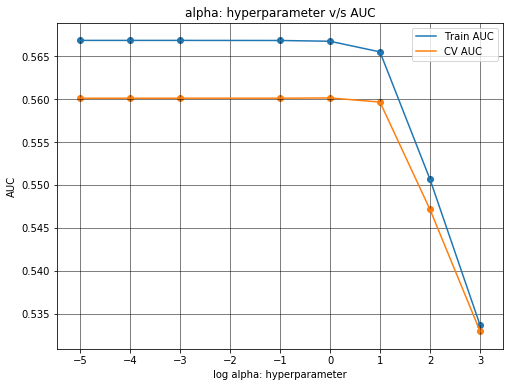

In [73]:
log_param=[]
for i in param['alpha']:
    b = np.log10(i)
    log_param.append(b) # fromm kaggle
    
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(log_param, train_auc, label='Train AUC')
plt.plot(log_param, cv_auc, label='CV AUC')  
plt.scatter(log_param,train_auc)
plt.scatter(log_param,cv_auc)
plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)


roc plot of train and test data

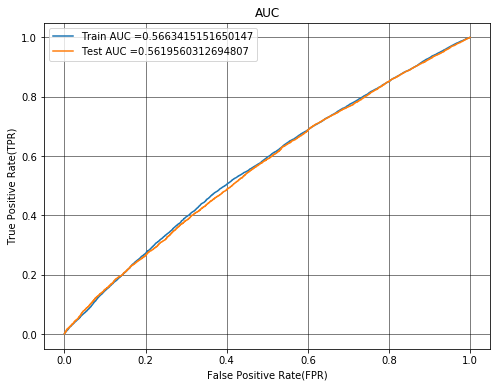

In [74]:
model_set1=MultinomialNB(alpha=1e-05,class_prior=[0.5,0.5])
model_set1.fit(X_tr_set_one,y_train)
y_train_probs = clf.predict_proba(X_tr_set_one)[:,1] 
y_test_probs= clf.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)

confusion matrix

In [75]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


Train data

the maximum value of tpr*(1-fpr) 0.3047364366324285 for threshold 0.515
CONFUSION MATRIX OF TRAIN DATA


[[ 6451  4632]
 [29594 32519]]


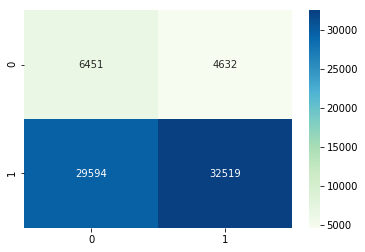

In [78]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

Test data

the maximum value of tpr*(1-fpr) 0.29871877909062683 for threshold 0.5
CONFUSION MATRIX OF TEST DATA


[[ 2941  2518]
 [13630 16963]]


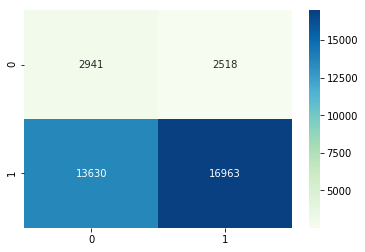

In [79]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

# MULTINOMIAL NAIVE BAYES USING GRID SEARCH CROSS VALIDATION (SET - 2)

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

model=MultinomialNB(class_prior=[0.5,0.5])
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}

clf=GridSearchCV(model,param,scoring='roc_auc',cv=10,return_train_score=True)
clf.fit(X_train_set_two,y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [84]:
print('Best score: ',clf.best_score_)
print('alpha value with best score: ',clf.best_params_)

Best score:  0.6721782514424637
alpha value with best score:  {'alpha': 1e-05}


plotting hyperparameter v/s auc

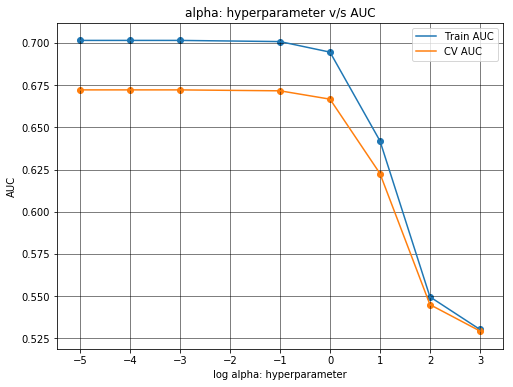

In [86]:
log_param=[]
for i in param['alpha']:
    b = np.log10(i)
    log_param.append(b) # fromm kaggle
    
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(log_param, train_auc, label='Train AUC')
plt.plot(log_param, cv_auc, label='CV AUC')  
plt.scatter(log_param,train_auc)
plt.scatter(log_param,cv_auc)
plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)

roc plot of train and test data

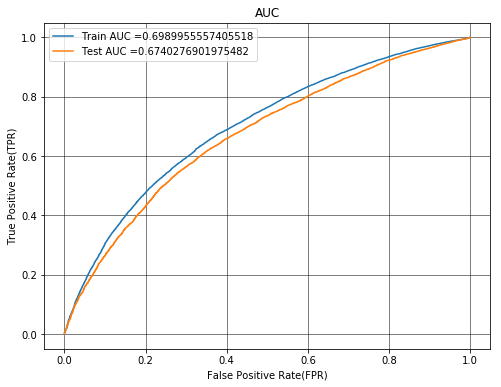

In [88]:
model_set2=MultinomialNB(alpha=1e-05,class_prior=[0.5,0.5])
model_set2.fit(X_train_set_two,y_train)
y_train_probs = clf.predict_proba(X_train_set_two)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_test_set_two )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)

# Confusion matrix

Train data

the maximum value of tpr*(1-fpr) 0.4219245437822276 for threshold 0.504
CONFUSION MATRIX OF TRAIN DATA


[[ 7382  3701]
 [22767 39346]]


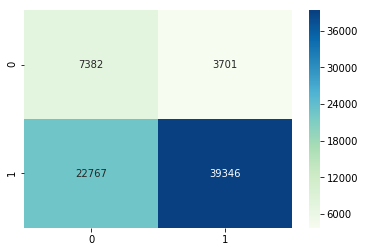

In [89]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')

Test data

the maximum value of tpr*(1-fpr) 0.40083302522783054 for threshold 0.511
CONFUSION MATRIX OF TEST DATA


[[ 3532  1927]
 [11640 18953]]


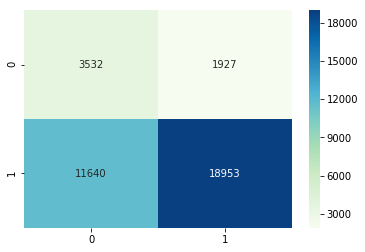

In [90]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu')


# Top 20 features from set-1

In [91]:
from scipy.sparse import hstack
X_train_set_two = hstack((X_train_essay_tfidf, X_train_teacher, X_train_project_grade, X_train_school_state, X_train_clean_categories, X_train_clean_subcategories, X_train_price_norm, X_train_submission_norm)).tocsr()
X_test_set_two = hstack((X_test_essay_tfidf, X_test_teacher, X_test_project_grade, X_test_school_state, X_test_clean_categories, X_test_clean_subcategories, X_test_price_norm, X_test_submission_norm)).tocsr()

In [93]:
features=[]
for fe in vectorizer_bow.get_feature_names() :
    features.append(fe)
    
for fe in vectorizer_state.get_feature_names() :
    features.append(fe)
    
for fe in vectorizer_prefix.get_feature_names() :  # adding all features into list as the order of data frame
    features.append(fe)
    
for fe in vectorizer_grade.get_feature_names() :
    features.append(fe)
    
features.append("price")

for fe in vectorizer_category.get_feature_names() :
    features.append(fe)
    
for fe in vectorizer_subcategory.get_feature_names() :
    features.append(fe)
    
features.append("teacher_number_of_previously_posted_projects")

In [94]:
class_0=model_set1.feature_log_prob_[0, :].argsort()
class_1=model_set1.feature_log_prob_[1, :].argsort()

In [96]:
print("top 20 features of class_0:")
print(np.take(features, class_0[-20:]))

top 20 features of class_0:
['ability learn' '8th graders' '25' '90 students' 'abilities' '21st'
 'able provide students' '85' '1st' 'able listen' '19' 'able learn'
 '1st grade' 'able make' '80 students' '7th grade' '99' '8th grade' '98'
 '7th 8th']


In [98]:
print("top 20 features of class_1:")
print(np.take(features, class_1[-20:]))

top 20 features of class_1:
['8th' '8th graders' '21st' 'abilities' 'able provide students'
 '90 students' '25' '85' 'able listen' '1st' '1st grade' 'able make'
 'able learn' '19' '80 students' '7th grade' '99' '8th grade' '98'
 '7th 8th']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [99]:
from prettytable import PrettyTable
table=PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Parameter", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row(["BOW", "Naive Bayes", 1e-05, 0.690])
table.add_row(["TFIDF", "Naive Bayes", 1e-05, 0.676])
print(table)

+------------+-------------+-----------------+----------+
| Vectorizer |    Model    | Hyper Parameter | Test-AUC |
+------------+-------------+-----------------+----------+
|    BOW     | Naive Bayes |      1e-05      |   0.69   |
|   TFIDF    | Naive Bayes |      1e-05      |  0.676   |
+------------+-------------+-----------------+----------+
